### CPS_Labor_Market_Grapher

Updated: May 21, 2018 

Brian Dew, @bd_econ

-----

Make decent looking line graphs for various labor market indicators.

TO DO:

Option for part-time for economic reasons and part time for noneconomic reasons

Option for up to three lines.

Usual weekly hours as an option.

UHE/UWE -- try to match with other published data

In [1]:
# Preliminaries--load packages and settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
import pandas as pd
import numpy as np
import wquantiles

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

In [2]:
# Consumer Price Index to adjust nominal prices
cpi = pd.read_csv('cpi.csv')
cpi.index = pd.to_datetime(cpi.date)

In [3]:
# Functions that get labor force data from the CPS and graph it
def get_cps_data(filters, calc_type, decile=0.5, rtype='share'):
    """Filter the database and calculate labor market stat"""
    data = pd.Series()
    for year in range(1994, 2019):
        d = pd.read_feather(f'data/cps_{year}.ft', nthreads=3)
        for month in range(1, 13):
            df = d[(d['HRMONTH'] == month)]
            if len(df) > 0:
                df = df.query(filters)
                if calc_type == 'epop':
                    empl = np.where(df['PREMPNOT']==1, 1, 0)
                    epop = np.average(empl, weights=df['PWSSWGT'])
                    data[pd.to_datetime(f'{year}-{month}-01')] = epop * 100
                if calc_type == 'unemp':
                    un = np.where(df['PREMPNOT']==2, 1, 0)
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWSSWGT'] * un).sum() / (df['PWSSWGT'] * lf).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100
                if calc_type == 'lfpr':
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWSSWGT'] * lf).sum() / (df['PWSSWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100
                if calc_type == 'resp':
                    same = np.where(df['PUIODP1']==1, 1, 0)
                    resp = np.where((df['PUIODP1']==1) & (df['PUIODP2']==1), 1, 0)
                    resh = (df['PWSSWGT'] * resp).sum() / (df['PWSSWGT'] * same).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = resh * 100
                if calc_type == 'selfuninc':
                    seu = np.where(((df['PEIO1COW']==7) | (df['PEIO2COW']==7)), 1, 0)
                    seurt = (df['PWSSWGT'] * seu).sum() / (df['PWSSWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = seurt * 100
                if calc_type == 'mjh':
                    mjh = np.where(df['PRSJMJ']==2, 1, 0)
                    jh = np.where(df['PRSJMJ'].isin([1,2]), 1, 0)
                    mjs = (df['PWSSWGT'] * mjh).sum() / (df['PWSSWGT'] * jh).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = mjs * 100
                if calc_type == 'total':
                    if rtype == 'level':
                        tot = (df['PWSSWGT'] / 100000000).sum() / 100
                    else:
                        tot = (df['PWSSWGT']).sum() / (d[(d['HRMONTH'] == month)]['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = tot
                # Following based on:
                # https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx
                if calc_type == 'disc':
                    dw = np.where(df['PEDWWNTO'].isin([1]), 1, 0)
                    if rtype == 'level':
                        dwrt = ((df['PWSSWGT'] / 100000000) * dw).sum() / 100
                    else:
                        dwrt = (df['PWSSWGT'] * dw).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = dwrt 
                if calc_type == 'nilfsch':
                    ns = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==3), 1, 0)
                    if rtype == 'level':
                        scrt = ((df['PWSSWGT'] / 100000000) * ns).sum() / 100
                    else:
                        scrt = (df['PWSSWGT'] * ns).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = scrt
                if calc_type == 'disill':
                    nd = np.where(((df['PRWNTJOB']==2) & 
                                   ((df['PEMLR']==6) | 
                                    (df['PENLFACT']==1) | 
                                    (df['PENLFACT']==2))), 1, 0)
                    if rtype == 'level':
                        di = ((df['PWSSWGT'] / 100000000) * nd).sum() / 100
                    else:                    
                        di = (df['PWSSWGT'] * nd).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = di
                if calc_type == 'care':
                    care = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==4), 1, 0)
                    if rtype == 'level':
                        ncare = ((df['PWSSWGT'] / 100000000) * care).sum() / 100
                    else:                      
                        ncare = (df['PWSSWGT'] * care).sum() / (df['PWSSWGT']).sum() * 100 
                    data[pd.to_datetime(f'{year}-{month}-01')] = ncare
                if calc_type == 'union':
                    tot = np.where(df['PEERNLAB'].isin([1, 2]), 1, 0)
                    union = np.where(df['PEERNLAB'] == 1, 1, 0)
                    if rtype == 'level':
                        unsh = ((df['PWORWGT'] / 100000000) * union).sum() / 100
                    else:
                        unsh = (df['PWORWGT'] * union).sum() / (df['PWORWGT'] * tot).sum() * 100 
                    data[pd.to_datetime(f'{year}-{month}-01')] = unsh               
                if calc_type in ['uwe', 'uwe_gr', 'uwe_r', 'uwe_r_gr']:
                    uwe = wquantiles.quantile(
                        df['PRERNWA'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{month}-01')] = uwe
                if calc_type in ['uhe', 'uhe_gr', 'uhe_r']:
                    uhe = wquantiles.quantile(
                        df['PRERNHLY'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{month}-01')] = uhe
        if calc_type in ['quwe_r', 'quwe']:
            for q in [('Q1', [1, 2, 3]), ('Q2', [4, 5, 6]), ('Q3', [7, 8, 9]), ('Q4', [10, 11, 12])]:
                df = d[(d['HRMONTH'].isin(q[1]))]
                if len(df['HRMONTH'].unique()) > 2:
                    df = df.query(filters)
                    quwe = wquantiles.quantile(
                        df['PRERNWA'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{q[0]}')] = quwe
    
    # Price adjustment for real wage series
    if calc_type in ['uwe_r', 'uhe_r', 'quwe_r', 'uwe_r_gr']:
        data = pd.concat([data, cpi['CPIAUCSL']], axis=1)
        data = (data[0] * data['CPIAUCSL'].iloc[-1]) / data['CPIAUCSL']
        
    # Growth if wage series
    if calc_type in ['uwe_gr', 'uhe_gr', 'uwe_r_gr']:
        data = data.rolling(12).mean().pct_change(12) * 100
        
    if calc_type not in ['quwe_r', 'quwe', 'uwe_gr', 'uhe_gr']:
        data = data.rolling(12).mean().dropna()
    
    # Take one-year moving average to smooth out seasonality and noise
    return data.dropna()

def labor_mkt_grapher(title, data, color, decimals=1):
    """Graph the labor market! """
    spcr, spcr2 = (data.max() - data.min()) / 26, (data.max() - data.min()) / 40
    ax = data.plot(title=title, figsize=(8, 4), color=color)
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color, s=25)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
    if decimals == 1:
        ax = plt.annotate(f'   {data[-1]: .1f}%', (data.index[-1], data[-1]-spcr2))
        ax = plt.xlabel('Source: Current Population Survey microdata, 12-month moving average')
    else:
        ax = plt.annotate(f'   ${data[-1]: .2f}', (data.index[-1], data[-1]-spcr2))
        ax = plt.xlabel('Source: Current Population Survey microdata, adjusted for inflation by CPI-U')
    ax = plt.annotate(f'  {data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')

C:\Users\BDew\Miniconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


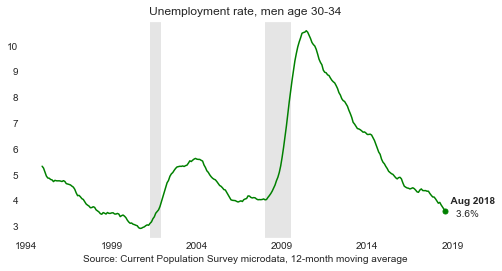

In [4]:
# Unemployment Rate
filters = 'PRTAGE >= 30 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'unemp'
title = 'Unemployment rate, men age 30-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

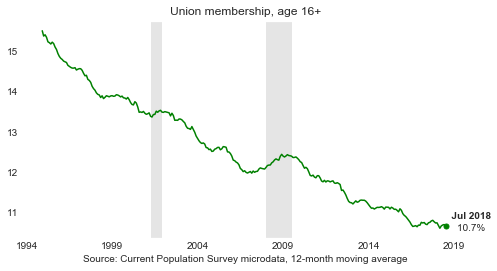

In [7]:
# Calculate total group size (millions)
filters = 'PRTAGE > 15'
calc_type = 'union'
title = 'Union membership, age 16+'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

In [ ]:
# Calculate total group size (millions)
filters = 'PRTAGE > 24 and PRTAGE < 55 and PRDTIND1 == 4'
calc_type = 'resp'
title = 'Same job, new responsibilities'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

C:\Users\BDew\Miniconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


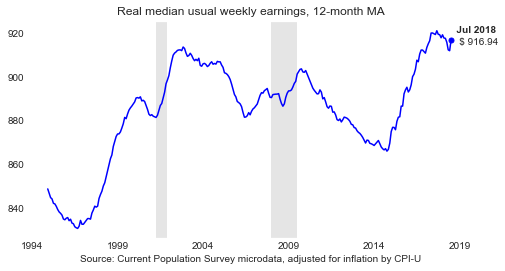

In [11]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRERNWA > 0 and PRTAGE > 24 and PRTAGE < 55'
calc_type = 'uwe_r'
title = 'Real median usual weekly earnings, 12-month MA'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'blue', decimals=2)
#plt.savefig('uwe.png', bbox_inches='tight', dpi=100)

In [11]:
df = pd.concat([data,data2], axis=1)

In [12]:
df.columns = ['25-54', '16+']

In [13]:
df.to_csv('cps_uwe_r.csv')

In [ ]:
# Weekly wage growth
filters = 'PRTAGE > 24 and PRTAGE < 55 and PESEX == 2 and PRFTLF == 1 and PRERNWA > 0 and PEEDUCA < 43'
calc_type = 'uwe_r'
title = "Real median usual weekly earnings, women age 25-54, less than bachelor's degree, 12-month MA"
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'red')
plt.savefig('uwe_ba.png', bbox_inches='tight', dpi=100)

In [7]:
# Hourly wage growth
filters = 'PRERNWA > 0 and PRFTLF == 1 and PRDTRACE == 2 and PRTAGE > 44 and PRTAGE < 55'
calc_type = 'uwe_r_gr'
title = 'Median real weekly earnings growth, black, under age 35'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'blue')

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
# Calculate total group size (millions)
filters = 'PRTAGE > 24 and PRTAGE < 55 and PESEX == 2 and PEEDUCA == 40'
calc_type = 'total'
title = 'Population in millions, women age 25-54, less than bachelor degree'
data = get_cps_data(filters, calc_type, rtype='level')
labor_mkt_grapher(title, data, 'orange')
#plt.savefig('pop_ltba.png', bbox_inches='tight', dpi=100)

In [ ]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRERNWA > 50'
calc_type = 'uwe'
title = 'Median weekly wage growth'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'purple')

C:\Users\BDew\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


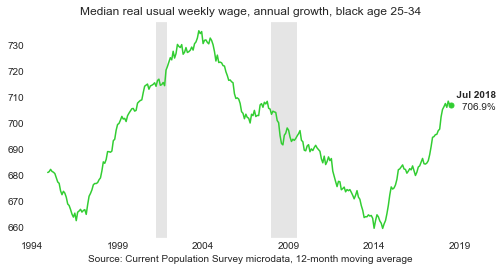

In [6]:
# Weekly wage growth
filters = 'PRTAGE > 24 and PRTAGE < 35 and WBHAO == 1 and PRFTLF == 1 and PRERNHLY > 0'
calc_type = 'uwe_r'
title = 'Median real usual weekly wage, annual growth, black age 25-34'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'limegreen')

In [ ]:
pd.concat([data, cpi['CPIAUCSL']], axis=1)['CPIAUCSL'].iloc[-1]

In [ ]:
# Discouraged worker, or conditionally available
filters = 'PRTAGE > 22 and PRTAGE < 34 and PESEX == 2 and WBHAO == 4'
calc_type = 'nilfsch'
title = 'School, NILF, % of white women age 22-34, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'purple')

The employment to population ratio calculates what share of the total population ($P$), has a job. It is calculated from the Current Population Survey (CPS).

In [ ]:
# Employment to Population Ratio
filters = 'PRTAGE >= 25 and PRTAGE <= 54 and WBHAO == 1'
calc_type = 'epop'
title = 'Percent of whites age 25-54 with a job, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

### The share of men age 25-34 with a job has not recovered from its 2000 peak

There are essentially three labor force categories: employed, unemployed, and not in the labor force.

$$Population = Employed + Unemployed + Not \ in \ Labor \ Force$$

The employment-population ratio (above) is therefore $\frac{Employed}{Population}$. $Unemployed$ and $Not \ in \ Labor \ Force$ are different; $Unemployed$ counts those actively looking for work or recently layed off. People can be outside the labor force for many reasons, some more subject to economic factors than others.

The CPS gives 100,000 people a chance to tell their story each month, including why they are not in the labor force. We can use the survey responses to summarize trends across groups.

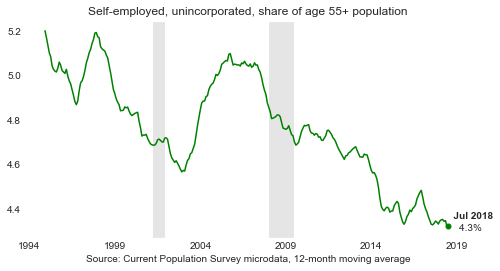

In [6]:
# Self-employed, unincorporated
filters = 'PRTAGE >= 55'
calc_type = 'selfuninc'
title = 'Self-employed, unincorporated, share of age 55+ population'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

C:\Users\BDew\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


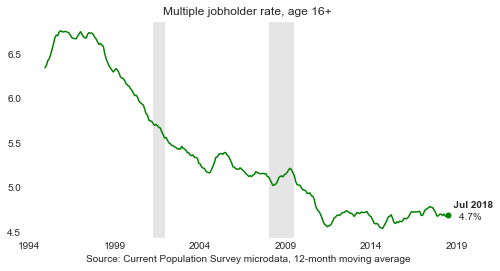

In [7]:
# Unemployment Rate
filters = 'PRTAGE >= 25 and PRTAGE <= 54 and PESEX==1'
calc_type = 'mjh'
title = 'Multiple jobholder rate, age 16+'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

In [83]:
dft

,women,men
1994-12-01,6.078763,6.342681
1995-01-01,6.109074,6.364302
1995-02-01,6.169641,6.420449
1995-03-01,6.224736,6.441503
1995-04-01,6.244699,6.487578
1995-05-01,6.325673,6.549198
1995-06-01,6.378775,6.607098
1995-07-01,6.408107,6.678022
1995-08-01,6.447947,6.707838
1995-09-01,6.459997,6.700883


In [120]:
dft.loc['2017', 'women'].mean()

5.5572691554854465

In [36]:
dft['seupa'] = data

In [112]:
dft = pd.read_csv('mjh.csv')

In [113]:
dft.index = pd.to_datetime(dft['Unnamed: 0'])

In [91]:
dft = dft[['women', 'men']]

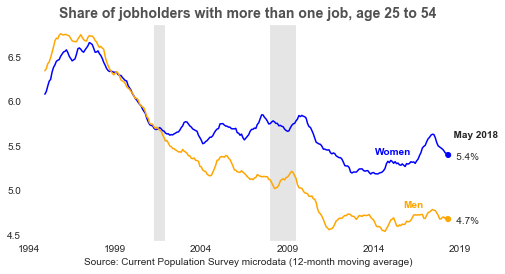

In [100]:
color = ['blue', 'orange']
title = 'Share of jobholders with more than one job, age 25 to 54'
ax = dft.plot(figsize=(8, 4), color=color, legend=False)
ax = plt.scatter([dft.index[-1]] * len(dft.iloc[-1]), [dft.iloc[-1]], color=color, s=25)
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
    ax = plt.xlabel('Source: Current Population Survey microdata (12-month moving average)')
ax = plt.annotate(f'  {dft.index[-1]:%b %Y}', (dft.index[-1], max(dft.iloc[-1])+0.2), 
                    fontweight='bold')
ax = plt.annotate(f'Women', (dft.index[230], 5.4), color='blue', 
                    fontweight='bold')
ax = plt.annotate(f'Men', (dft.index[250], 4.8), color='orange', 
                    fontweight='bold')
ax = plt.annotate(f'  {dft["women"].iloc[-1]:4.1f}%', (dft.index[-1],dft['women'].iloc[-1]-0.05))
ax = plt.annotate(f'  {dft["men"].iloc[-1]:4.1f}%', (dft.index[-1],dft['men'].iloc[-1]-0.05))
plt.title(title, size=14, weight='bold', alpha=0.8, x=0.5)
plt.savefig('mjh.png', bbox_inches='tight', dpi=250)

In [57]:
dft['seu55'].iloc[-1]

4.346438380643818

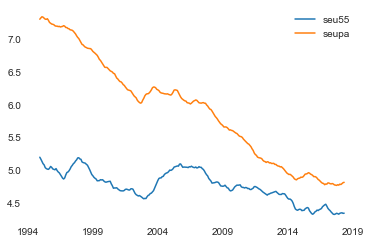

In [39]:
dft.plot()

The unemployment rate has more or less recovered, unlike the employment to population ratio. It is calculated as the unemployed population divided by the labor force, $\frac{Unemployed}{(Employed+Unemployed)}$. We can also look at the labor force participation rate, $\frac{(Employed+Unemployed)}{Population}$, the least recovered of the three measures. 

In [ ]:
# Labor force participation rate
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'lfpr'
title = 'Labor force participation rate, men age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

### Women

In [ ]:
# Care for other, not in labor force
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 25-34, 12-mo moving avg'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')
plt.savefig('caregiving.png', bbox_inches='tight', dpi=500)

In [ ]:
# Care for other, not in labor force
filters = 'PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2'
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 35-44, 12-mo moving avg'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Care for other, not in labor force
filters = 'PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 2'
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 45-54, 12-mo moving avg'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Care for other, not in labor force
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'care'
title = 'Caregiving, NILF, % of men age 25-34, 12-mo moving avg'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'darkorchid')
plt.savefig('caregiving.png', bbox_inches='tight', dpi=500)

C:\Users\BDew\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


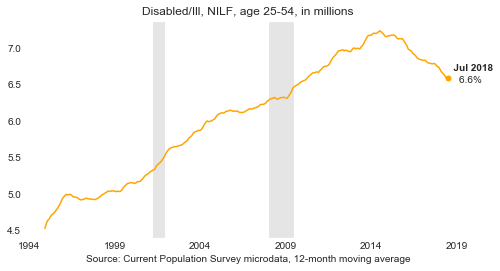

In [9]:
# Disabled/Ill, not in labor force
filters = 'PRTAGE >= 25 and PRTAGE <= 54'
calc_type = 'disill'
title = 'Disabled/Ill, NILF, age 25-54, in millions'
data = get_cps_data(filters, calc_type, rtype='level')
labor_mkt_grapher(title, data, 'orange')
plt.savefig('disill.png', bbox_inches='tight', dpi=100)

In [ ]:
# Disabled/Ill, not in labor force
filters = 'PRTAGE >= 25 and PRTAGE <= 54 and PESEX == 2'
calc_type = 'disill'
title = 'Disabled/Ill, NILF, women, age 25-54, in millions'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'midnightblue')

In [ ]:
# In school, not in labor force
filters = 'PRTAGE >= 22 and PRTAGE <= 24'
calc_type = 'nilfsch'
title = 'In school, not in labor force, age 22-24'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

In [ ]:
# In school, not in labor force
series = 'PENLFACT'
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'nilfsch'
title = 'In school, NILF, % of women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

In [ ]:
# In school, not in labor force
filters = 'PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2'
calc_type = 'nilfsch'
title = 'In school, NILF, % of women age 35-44'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'purple')

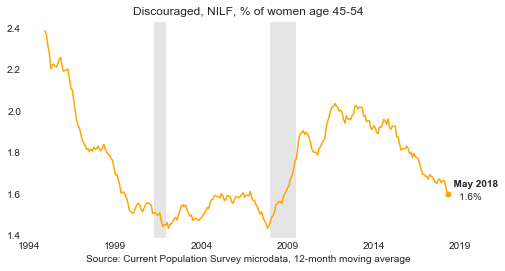

In [3]:
# Discouraged worker, or conditionally available
filters = 'PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 2'
calc_type = 'disc'
title = 'Discouraged, NILF, % of women age 45-54'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'orange')

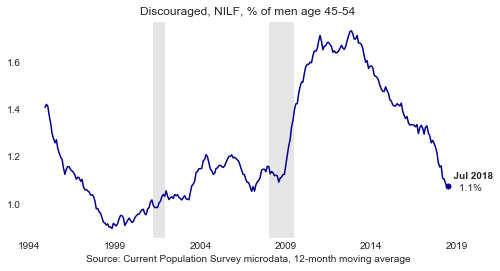

In [7]:
# Discouraged worker, or conditionally available
filters = 'PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 1'
calc_type = 'disc'
title = 'Discouraged, NILF, % of men age 45-54'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'darkblue')

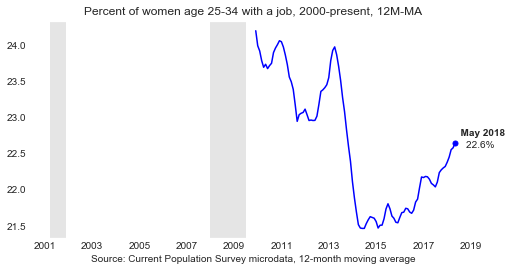

In [16]:
# Employment to Population Ratio
filters = 'PEDISEAR == 1'
calc_type = 'epop'
title = 'Percent of women age 25-34 with a job, 2000-present, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Unemployment Rate
calc_type = 'unemp'
title = 'Unemployment rate, women age 25-34, 2000-present, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

In [ ]:
# Labor force participation rate
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'lfpr'
title = 'Labor force participation rate, women age 25-34, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')
plt.savefig('lfpr.png', bbox_inches='tight', dpi=500)

In [ ]:
# Employment to Population Ratio
filters = 'PEEDUCA >= 43 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'epop'
title = 'Employed % of college+ men age 25-34, 2000-present, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Unemployment Rate
calc_type = 'unemp'
title = 'Unemployment rate, college+ men age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

In [ ]:
# Labor force participation rate
filters = 'PEEDUCA >= 43 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'lfpr'
title = 'Labor force participation rate, college+ men age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

C:\Users\BDew\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


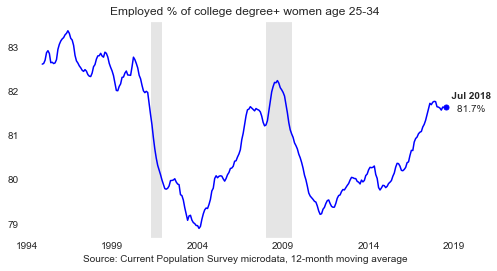

In [8]:
# Employment to Population Ratio
filters = 'PEEDUCA >= 43 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'epop'
title = 'Employed % of college degree+ women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Employment to Population Ratio
filters = 'PEEDUCA >= 43 and PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2'
calc_type = 'epop'
title = 'Employed % of college degree+ women age 35-44'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Employment to Population Ratio
filters = 'PEEDUCA >= 43 and PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 2'
calc_type = 'epop'
title = 'Employed % of college degree+ women age 45-54'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

In [ ]:
# Unemployment Rate
filters = 'PEEDUCA >= 43 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'unemp'
title = 'Unemployment rate, college+ women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

In [ ]:
# Labor force participation rate
calc_type = 'lfpr'
title = 'Labor force participation rate, college+ women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

In [ ]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2 and PRERNWA > 0'
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 25-34, 12M-MA'
data = get_cps_data(filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')

In [ ]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2 and PRERNWA > 0'
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 35-44'
data = get_cps_data(filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')

In [ ]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 2 and PRERNWA > 0'
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 45-54'
data = get_cps_data(filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')

In [ ]:
# Mini example of how labor force has aged
d = {}
for year in [2001, 2017]:
    d[year] = {}
    df = pd.read_feather(f'data/cps_{year}.ft', nthreads=3)
    for age in range (16, 80):
        dft = df[df['PRTAGE'] == age]
        empl = np.where(dft['PREMPNOT'] == 1, 1.0, 0.0)
        epop = np.average(empl, weights=dft['PWCMPWGT'])
        d[year][age] = epop
        
ax = pd.DataFrame(d).plot(title='Employed share of population by age, (25-54 highlighted)')
ax = plt.axvspan(25, 54, fill=True, linewidth=0, color='gray', alpha=0.1) 